In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import smlmodule

from itertools import combinations

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "sum_wpm10_ex_q75_period1_2020,"+\
        "sum_wpm2p5_ex_q75_period1_2020,"+\
        "sum_wno2_ex_q75_period1_2020,"+\
        "sum_wno_ex_q75_period1_2020,"+\
        "sum_wnh3_ex_q75_period1_2020,"+\
        "sum_wpans_ex_q75_period1_2020,"+\
        "sum_wnmvoc_ex_q75_period1_2020,"+\
        "sum_wo3_ex_q75_period1_2020,"+\
        "sum_wco_ex_q75_period1_2020,"+\
        "sum_wso2_ex_q75_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   vercelli
   2   pistoia
   3   caserta
   4   piacenza
   5   monza
   6   macerata
   7   cagliari
   8   bergamo
   9   biella
   10   massa
   11   foggia
   12   alessandria
   13   varese
   14   lecco
   15   parma
   16   teramo
   17   salerno
   18   pordenone
   19   asti
   20   siena
   21   modena
   22   cosenza
   23   avellino
   24   trento
   25   catania
   26   ferrara
   27   napoli
   28   ascoli_piceno
   29   rovigo
   30   vibo_valentia
   31   fermo
   32   bolzano
   33   roma
   34   cuneo
   35   sondrio
   36   sassari
   37   rieti
   38   milano
   39   isernia
   40   firenze
   41   prato
   42   reggio_nell_emilia
   43   como
   44   forli
   45   grosseto
   46   belluno
   47   lucca
   48   bat
   49   brindisi
   50   savona
   51   brescia
   52   padova
   53   pesaro
   54   lodi
   55   campobasso
   56   mantova
   57   benevento
   58   enna
   59   messina
   

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    if cases > 0.0 and diff < 5.0:
        counter += 1

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", "lat", "Ratio0200ver65"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))
    
    ycasi = cases/popolazione

    if cases > 0.0 and diff < 5.0:
        ylogpropcasi.append(math.log(ycasi))

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 


        i = i + 1

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Using:                        density
Using:               commutersdensity
Using:                         depriv
Using:                            lat
Using:                 Ratio0200ver65
Using:  sum_wpm10_ex_q75_period1_2020
Using:   sum_wno2_ex_q75_period1_2020
Using:

Training set average RMSE:  0.34913  0.02394 
    Test set average RMSE:  0.98569  0.08839 
             Fullset RMSE:  0.35204
                       R2:  0.94329


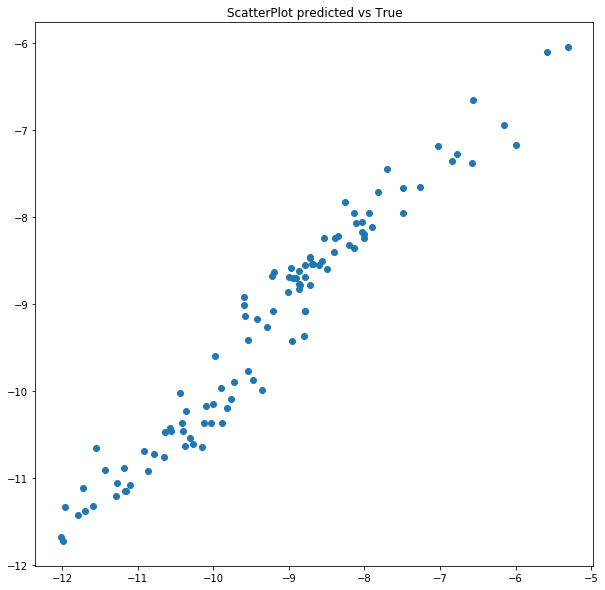

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05503
Feature:               commutersdensity, Score: 0.03157
Feature:                         depriv, Score: 0.05828
Feature:                            lat, Score: 0.69188
Feature:                 Ratio0200ver65, Score: 0.07932
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.00744
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.00943
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02648
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00779
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.01962
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00841
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00477


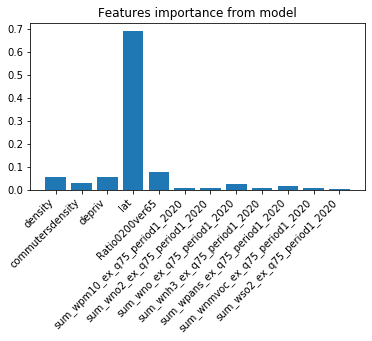

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.11159
Feature:               commutersdensity, Score: 0.06296
Feature:                         depriv, Score: 0.15765
Feature:                            lat, Score: 3.26136
Feature:                 Ratio0200ver65, Score: 0.20793
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02923
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.02170
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.08263
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.01896
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04918
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01221
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01063


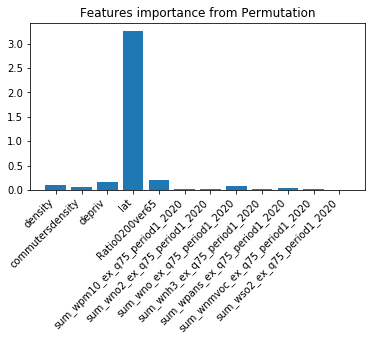

<Figure size 720x720 with 0 Axes>

((0.34913241608250656, 0.02394184007863985),
 (0.985685737072632, 0.08839049102683175),
 0.35203867763295116,
 {'density': 0.027717238352156698,
  'commutersdensity': 0.01563841405817577,
  'depriv': 0.03915829279072742,
  'lat': 0.8100695640556108,
  'Ratio0200ver65': 0.051645735599660375,
  'sum_wpm10_ex_q75_period1_2020': 0.007260769187098038,
  'sum_wno2_ex_q75_period1_2020': 0.005391141324233278,
  'sum_wno_ex_q75_period1_2020': 0.02052277323369817,
  'sum_wnh3_ex_q75_period1_2020': 0.0047085707573083745,
  'sum_wpans_ex_q75_period1_2020': 0.012214451250608447,
  'sum_wnmvoc_ex_q75_period1_2020': 0.0030329041900706,
  'sum_wso2_ex_q75_period1_2020': 0.0026401452006519148})

In [5]:
listostack = [features_dict[v] for v in features]
X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , features, N=50, pout=sys.stdout, showplot=True)